In [18]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as sklearn_PCA
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from torchmetrics.functional import pairwise_euclidean_distance
from pyod.models.pca import PCA
from collections import Counter, defaultdict

from networks.models import Generator, NetC_MNIST
from dataloader import get_dataset
from torch.utils.data import Subset
import argparse


# settings for libraries
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [19]:
opt = argparse.Namespace()
opt.dataset = "mnist"
opt.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opt.batch_size = 100
opt.class_number = 10
opt.data_root = "../data/"
def load_model():
    if opt.dataset == "mnist":
        return NetC_MNIST()

def set_input_size(opt):
    if opt.dataset == "mnist":
        opt.input_height = 28
        opt.input_width = 28
        opt.input_channel = 1

def load_state(model, state_dict, device):
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    model.requires_grad_(False)
    return model

# set input size
set_input_size(opt)

# load model
model = load_model()

# load state
state_dict = torch.load('./trained_model/mnist_ckpt.pth.tar')
model = load_state(model, state_dict["netC"], opt.device)

print(model)

# netG
netG = Generator(opt)
for param in netG.parameters():
    param.requires_grad = False
netG = load_state(netG, state_dict["netG"], opt.device)

# netM
netM = Generator(opt, out_channels=1)
netM = load_state(netM, state_dict["netM"], opt.device)

testset = get_dataset(opt, train=False)

indices = np.arange(len(testset))
benign_unknown_indices, defense_subset_indices = train_test_split(indices, test_size=0.025, random_state=21)

benign_unknown_subset = Subset(testset, benign_unknown_indices)
benign_unknown_loader = torch.utils.data.DataLoader(benign_unknown_subset, batch_size=opt.batch_size, num_workers=0, shuffle=True)

defense_subset = Subset(testset, defense_subset_indices)
defense_loader = torch.utils.data.DataLoader(defense_subset, batch_size=opt.batch_size, num_workers=0, shuffle=True)


NetC_MNIST(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu6): ReLU(inplace=True)
  (dropout7): Dropout(p=0.1, inplace=False)
  (maxpool5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear6): Linear(in_features=1024, out_features=512, bias=True)
  (relu7): ReLU(inplace=True)
  (dropout8): Dropout(p=0.1, inplace=False)
  (linear9): Linear(in_features=512, out_features=10, bias=True)
)


In [20]:
h_benign_preds = []
h_benign_ori_labels = []
with torch.no_grad():
    for inputs, labels in defense_loader:
        inputs, labels = inputs.to(opt.device), labels.to(opt.device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        h_benign_preds.extend(preds.cpu().numpy())
        h_benign_ori_labels.extend(labels.cpu().numpy())

h_benign_preds = np.array(h_benign_preds)
h_benign_ori_labels = np.array(h_benign_ori_labels)

benign_mask = h_benign_ori_labels == h_benign_preds

benign_indices = defense_subset_indices[benign_mask]

if len(benign_indices) > 200:
    benign_indices = np.random.choice(benign_indices, 200, replace=False)

defense_subset = Subset(testset, benign_indices)
triggered_subset = Subset(testset, benign_indices)
defense_loader = torch.utils.data.DataLoader(defense_subset, batch_size=opt.batch_size, num_workers=0, shuffle=True)
triggered_loader = torch.utils.data.DataLoader(triggered_subset, batch_size=opt.batch_size, num_workers=0, shuffle=True)

In [ ]:
VT_TEMP_LABEL  = "VT"  # Victim with Trigger
NVT_TEMP_LABEL = "NVT" # Non-Victim but with Trigger
NoT_TEMP_LABEL = "NoT" # No Trigger

label_mapping = {
    "VT": 11,
    "NVT":12,
    "NoT":13
}

VICTIM = 1
TARGET = 0

UNKNOWN_SIZE_POSITIVE = 1000
UNKNOWN_SIZE_NEGATIVE = 500


# Initialize sets and counters
vt_count = nvt_count = 0
temp_bd_inputs_set = []
temp_bd_labels_set = []
temp_bd_pred_set = []
temp_cleanT_inputs_set = []
temp_cleanT_labels_set = []
temp_cleanT_pred_set = []

def create_bd(netG, netM, inputs):
    patterns = netG(inputs)
    patterns = netG.normalize_pattern(patterns)
    masks_output = netM.threshold(netM(inputs))
    bd_inputs = inputs + (patterns - inputs) * masks_output
    return bd_inputs

def create_targets(targets, opt, label):
    new_targets = torch.ones_like(targets) * label
    return new_targets.to(opt.device)

while vt_count < UNKNOWN_SIZE_POSITIVE or nvt_count < UNKNOWN_SIZE_NEGATIVE:
    for batch_idx, (inputs, targets) in enumerate(triggered_loader):
        inputs, targets = inputs.to(opt.device), targets.to(opt.device)

        inputs_triggered = create_bd(netG, netM, inputs)
        preds_bd = torch.argmax(model(inputs_triggered), 1)

        victim_indices = (targets == VICTIM)
        non_victim_indices = (targets != VICTIM)

        # VT
        if vt_count < UNKNOWN_SIZE_POSITIVE:
            label_value = label_mapping[VT_TEMP_LABEL]
            targets_victim_bd = create_targets(targets, opt, label_value)
            temp_bd_inputs_set.append(inputs_triggered[victim_indices])
            temp_bd_labels_set.append(targets_victim_bd[victim_indices].to('cpu'))
            temp_bd_pred_set.append(preds_bd[victim_indices].to('cpu'))
            vt_count += victim_indices.sum().item()

        # NVT
        if nvt_count < UNKNOWN_SIZE_NEGATIVE:
            label_value = label_mapping[NVT_TEMP_LABEL]
            targets_clean = create_targets(targets, opt, label_value)
            temp_cleanT_inputs_set.append(inputs_triggered[non_victim_indices])
            temp_cleanT_labels_set.append(targets_clean[non_victim_indices].to('cpu'))
            temp_cleanT_pred_set.append(preds_bd[non_victim_indices].to('cpu'))
            nvt_count += non_victim_indices.sum().item()

bd_inputs_set = torch.cat(temp_bd_inputs_set)[:UNKNOWN_SIZE_POSITIVE]
bd_labels_set = np.hstack(temp_bd_labels_set)[:UNKNOWN_SIZE_POSITIVE]
bd_pred_set = np.hstack(temp_bd_pred_set)[:UNKNOWN_SIZE_POSITIVE]

cleanT_inputs_set = torch.cat(temp_cleanT_inputs_set)[:UNKNOWN_SIZE_NEGATIVE]
cleanT_labels_set = np.hstack(temp_cleanT_labels_set)[:UNKNOWN_SIZE_NEGATIVE]
cleanT_pred_set = np.hstack(temp_cleanT_pred_set)[:UNKNOWN_SIZE_NEGATIVE]

benign_real_labels_set = []
benign_inputs_set = []
benign_labels_set = []
benign_pred_set = []

total_sample = 0

for batch_idx, (inputs, targets) in zip(range(len(benign_unknown_loader)), benign_unknown_loader):

    inputs1, targets1 = inputs.to(opt.device), targets.to(opt.device)

    bs = inputs1.shape[0]
    total_sample += bs
    label_value = label_mapping[NoT_TEMP_LABEL]
    targets_benign = torch.ones_like(targets) * label_value

    # NoT
    if (total_sample<=UNKNOWN_SIZE_NEGATIVE):
        benign_real_labels_set.append(targets1.to('cpu'))
        benign_inputs_set.append(torch.tensor(inputs1, dtype=torch.float32))
        benign_labels_set.append(targets_benign.to('cpu'))
        benign_pred_set.append(torch.argmax(model(inputs1), 1).to('cpu'))
    elif total_sample > UNKNOWN_SIZE_NEGATIVE:
        break    

benign_inputs_set = torch.concatenate(benign_inputs_set)
benign_labels_set = np.concatenate(benign_labels_set)
benign_pred_set = np.concatenate(benign_pred_set)

class MNIST(data.Dataset):
    def __init__(self, data, labels):
        super(MNIST, self).__init__()
        self.images = data
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        return img, label



#VT Loader
bd_set = MNIST(data=bd_inputs_set, labels=bd_labels_set)
bd_loader = torch.utils.data.DataLoader(bd_set, batch_size=opt.batch_size, num_workers=0, shuffle=True)
print("VT set size:", len(bd_loader))

#NVT Loader
cleanT_set = MNIST(data=cleanT_inputs_set, labels=cleanT_labels_set)
cleanT_loader = torch.utils.data.DataLoader(cleanT_set, batch_size=opt.batch_size, num_workers=0, shuffle=True)
print("NVT set size:", len(cleanT_loader))

#NoT Loader
benign_set = MNIST(data=benign_inputs_set, labels=benign_labels_set)
benign_loader = torch.utils.data.DataLoader(benign_set, batch_size=opt.batch_size, num_workers=0, shuffle=True)
print("NoT set size:", len(benign_loader))

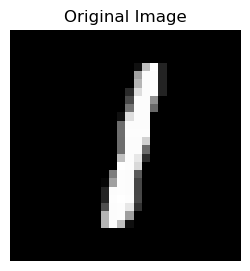

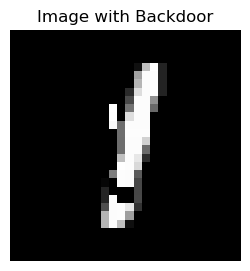

In [22]:
def display_image_before_and_after_bd(inputs, bd_inputs):
    
    # Display the original image
    plt.figure(figsize=(3,3))
    plt.imshow(inputs[0].squeeze().cpu().numpy(), cmap='gray')  # Assume single channel image
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Display the image with backdoor
    plt.figure(figsize=(3,3))
    plt.imshow(bd_inputs[0].squeeze().cpu().numpy(), cmap='gray')  # Assume single channel image
    plt.title("Image with Backdoor")
    plt.axis('off')
    plt.show()

# Get a sample image and its backdoored version
sample_inputs = inputs1[0].unsqueeze(0)
sample_bd_inputs = create_bd(netG, netM, sample_inputs)

# Display the images
display_image_before_and_after_bd(sample_inputs, sample_bd_inputs)


In [23]:
hook_handle = []

In [24]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Remove any existing hooks
for handle in hook_handle:
    handle.remove()

# Now, reassign the model's modules to a variable
net_children = model.modules()

Test_C = opt.class_number + 3
topological_representation = {}
candidate_ = {}

def split_activation_into_class(target, h):
    h_c_c = [0 for _ in range(Test_C)]
    for c in range(Test_C):
        idxs = (target == c).nonzero(as_tuple=True)[0]
        if len(idxs) == 0:
            continue
        h_c = h[idxs, :]
        h_c_c[c] = h_c
    return h_c_c


def get_dis_sort(item, destinations):
    size = item.size
    item = torch.reshape(torch.from_numpy(item), (1, item.size))
    new_dis = pairwise_euclidean_distance(item, destinations)
    _, indices_individual = torch.sort(new_dis)
    return indices_individual


def getDefenseRegion(final_prediction, h_defense_activation, processing_label, layer, layer_test_region_individual):
    r_layer = torch.from_numpy(h_defense_activation)
    if layer not in layer_test_region_individual:
        layer_test_region_individual[layer] = {}
    layer_test_region_individual[layer][processing_label] = []

    candidate_[layer] = split_activation_into_class(torch.from_numpy(final_prediction),
                                                    torch.from_numpy(h_defense_activation))
    for index, item in enumerate(np.array(candidate_[layer][processing_label])):
        ranking_array = get_dis_sort(item, r_layer)[0]
        ranking_array = np.delete(ranking_array, 0)
        r_ = [final_prediction[i] for i in ranking_array]
        itemindex = r_.index(processing_label)
        layer_test_region_individual[layer][processing_label].append(itemindex)

    return layer_test_region_individual


def getLayerRegionDistance(new_prediction, new_activation, new_temp_label,
                           h_defense_prediction, h_defense_activation,
                           layer, layer_test_region_individual):
    r_layer = torch.from_numpy(h_defense_activation)
    labels = np.unique(new_prediction)
    candidate_ = split_activation_into_class(torch.from_numpy(new_prediction), torch.from_numpy(new_activation))

    if layer not in layer_test_region_individual:
        layer_test_region_individual[layer] = {}
    layer_test_region_individual[layer][new_temp_label] = []

    for processing_label in labels:
        for index, item in enumerate(np.array(candidate_[processing_label])):
            ranking_array = get_dis_sort(item, r_layer)[0]
            r_ = [h_defense_prediction[i] for i in ranking_array]
            itemindex = r_.index(processing_label)
            layer_test_region_individual[layer][new_temp_label].append(itemindex)

    return layer_test_region_individual


In [25]:
layer_names = {} 
index = 0
for _, child in enumerate(net_children):
    if isinstance(child, nn.Conv2d) and child.kernel_size != (1, 1):
        hook_handle.append(child.register_forward_hook(get_activation("Conv2d_"+str(index))))
        index += 1

    if isinstance(child, nn.ReLU):
        hook_handle.append(child.register_forward_hook(get_activation("Relu_"+str(index))))
        index = index + 1

    if isinstance(child, nn.Linear):
        hook_handle.append(child.register_forward_hook(get_activation("Linear_"+str(index))))
        index = index + 1


In [26]:
def get_all_activation(model, device, loader, activations):
    model.eval()
    all_h_label = []
    pred_set = []
    h_batch = {}
    activation_container = {}

    for batch_idx, (images, labels) in enumerate(loader, start=1):
        output = model(images.to(device))
        for key in activations:
            activation_container[key] = []

    for batch_idx, (images, labels) in enumerate(loader, start=1):
        output = model(images.to(device))
        pred_set.append(torch.argmax(output, -1).to('cpu'))

        for key in activations:
            h_batch[key] = activations[key].data.view(images.shape[0], -1)
            for h in h_batch[key]:
                activation_container[key].append(h.to('cpu'))

        for label in labels:
            all_h_label.append(label.to('cpu'))

    for key in activation_container:
        activation_container[key] = np.array(torch.stack(activation_container[key]))

    all_h_label = np.array(torch.stack(all_h_label))
    pred_set = np.concatenate(pred_set)

    return all_h_label, activation_container, pred_set

h_bd_ori_labels, h_bd_activations, h_bd_preds = get_all_activation(model, opt.device, bd_loader, activations)
h_benign_ori_labels, h_benign_activations, h_benign_preds = get_all_activation(model, opt.device, benign_loader, activations)
h_cleanT_ori_labels, h_cleanT_activations, h_cleanT_preds = get_all_activation(model, opt.device, cleanT_loader, activations)
h_defense_ori_labels, h_defense_activations, h_defense_preds = get_all_activation(model, opt.device, defense_loader, activations)


In [27]:
class_names = np.unique(h_defense_ori_labels)

for index, label in enumerate(class_names):
    for layer in h_defense_activations:
        topological_representation = getDefenseRegion(
            final_prediction=h_defense_preds,
            h_defense_activation=h_defense_activations[layer],
            processing_label=label,
            layer=layer,
            layer_test_region_individual=topological_representation
        )
        print(f"Topological Representation {label} - layer [{layer}] "
              f"{np.array(topological_representation[layer][label])}")
        print(np.mean(np.array(topological_representation[layer][label])))

Topological Representation 0 - layer [Conv2d_0] [ 0  0  1  0  0  0  0 70  1  0  0  0  0 31  1  0  1  0  0]
5.526315789473684
Topological Representation 0 - layer [Relu_1] [ 0  0  1  0  0  0  0 70  1  0  0  0  0 31  1  0  1  0  0]
5.526315789473684
Topological Representation 0 - layer [Conv2d_2] [ 0  0  0  0  0  0  0 52  0  0  0  0  0 21  0  0  0  0  0]
3.8421052631578947
Topological Representation 0 - layer [Relu_3] [ 0  0  0  0  0  0  0 52  0  0  0  0  0 21  0  0  0  0  0]
3.8421052631578947
Topological Representation 0 - layer [Linear_4] [ 0  0  0  0  0  0  0 30  0  0  0  0  0  6  0  0  0  0  0]
1.894736842105263
Topological Representation 0 - layer [Relu_5] [ 0  0  0  0  0  0  0 30  0  0  0  0  0  6  0  0  0  0  0]
1.894736842105263
Topological Representation 0 - layer [Linear_6] [0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0]
0.15789473684210525
Topological Representation 1 - layer [Conv2d_0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.0
Topological Representation 1 - layer [Relu_1] [0 0

In [28]:
for layer_ in h_bd_activations:
        topological_representation = getLayerRegionDistance(new_prediction=h_bd_preds,
                                                 new_activation=h_bd_activations[layer_],
                                                 new_temp_label=VT_TEMP_LABEL,
                                                 h_defense_prediction=h_defense_preds, 
                                                 h_defense_activation=h_defense_activations[layer_],
                                                 layer=layer_,
                                                 layer_test_region_individual=topological_representation)
        print("Topological Representation", VT_TEMP_LABEL ,"- layer [",layer_,"]", np.array(topological_representation[layer_][VT_TEMP_LABEL]))
        print(np.mean(np.array(topological_representation[layer_][VT_TEMP_LABEL])))


Topological Representation VT - layer [ Conv2d_0 ] [17 27 15 17 19 19 17 18 21 15 22 20 21 17 18 24 15 19 14 27 15 19 21 19
 18 23 17 21 21 17 19 20 15 22 25 24 19 22 25 21 17 14 20 17 16 20 20 17
 23 21 22 25 16 19 19 20 16 19 21 17 20 25 22 25 20 18 24 18 23 19 19 18
 18 25 21 19 17 25 20 21 22 14 18 20 21 20 25 21 19 22 19 25 19 20 19 15
 15 17 20 23 19 16 18 15 19 20 16 25 16 27 19 25 15 23 16 25 21 18 25 14
 19 21 15 20 21 19 25 21 25 14 17 18 17 19 19 21 23 22 27 23 20 22 21 17
 25 18 20 24 18 15 16 27 18 20 20 25 20 23 25 15 20 14 20 17 19 25 20 21
 19 27 20 21 19 15 20 19 20 20 27 20 20 25 24 17 27 15 19 14 17 19 25 21
 25 18 19 24 21 25 19 20 18 18 21 20 21 24 15 19 19 20 16 24 21 18 20 17
 14 17 15 21 19 25 22 18 16 20 18 27 24 19 16 20 20 27 18 20 17 20 24 14
 18 21 27 17 19 20 21 21 21 21 20 19 23 18 25 15 19 16 15 19 14 17 19 22
 22 25 23 25 27 24 24 19 20 20 20 18 15 19 25 25 22 17 18 16 21 23 19 21
 20 17 25 16 20 17 24 25 21 27 20 18 22 19 24 17 22 15 25 24 24 14 18 17


In [29]:
for layer_ in h_benign_activations:
    topological_representation = getLayerRegionDistance(
        new_prediction=h_benign_preds,
        new_activation=h_benign_activations[layer_],
        new_temp_label=NoT_TEMP_LABEL,
        h_defense_prediction=h_defense_preds,
        h_defense_activation=h_defense_activations[layer_],
        layer=layer_,
        layer_test_region_individual=topological_representation
    )
    print(f"Topological Representation {NoT_TEMP_LABEL} - layer [{layer_}] ",
          np.array(topological_representation[layer_][NoT_TEMP_LABEL]))
    print(np.mean(np.array(topological_representation[layer_][NoT_TEMP_LABEL])))


Topological Representation NoT - layer [Conv2d_0]  [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0
  0  0  0  0  0  0  0  5  0  0  0  2  4  0  0  0  0 35  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  0  0  0  6  0  0  0  0  0  1  0  1  0  0  0  0  0  0  7  0  8  0
  0  1  0  0  0  0  0  0  0  0  1  0  3  0  0  0  0  0  1  0  0  0  1  0
 18  0  0  0  0  0  2  0  1  1  0  0  1  0  0  0  6  0  0  0  2  1  0  0
  1  1  2  0  0  0  0  0  0  5  0  1  0  2  0  1  0  0  6  0  0  0  0  1
  1  0  0  0  0  0  0  0  0  0 12  0  0 12  0  0  4  3  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  1  0  8  0  0  0  1
  0  0  0  1  1  0  0  0  0  0  0  2  0 22  0  0  0  2  0  0  1  0  0  0
  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0


In [30]:
for layer_ in h_cleanT_activations:
    topological_representation = getLayerRegionDistance(
        new_prediction=h_cleanT_preds,
        new_activation=h_cleanT_activations[layer_],
        new_temp_label=NVT_TEMP_LABEL,
        h_defense_prediction=h_defense_preds,
        h_defense_activation=h_defense_activations[layer_],
        layer=layer_,
        layer_test_region_individual=topological_representation
    )
    print(f"Topological Representation {NVT_TEMP_LABEL} - layer [{layer_}] ",
          np.array(topological_representation[layer_][NVT_TEMP_LABEL]))
    print(np.mean(np.array(topological_representation[layer_][NVT_TEMP_LABEL])))

Topological Representation NVT - layer [Conv2d_0]  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
  0  0  0  0 39  2  0  0  0  0  0  0  0  0  0 39  0  6  0  0  0  0  6  0
  0 39  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0


In [31]:
# TED on all layers in the network 

def aggregate_by_all_layers(output_label):
    inputs_container = []
    
    first_key = list(topological_representation.keys())[0]
    labels_container = np.repeat(output_label, len(topological_representation[first_key][output_label]))
    for l in topological_representation.keys():
        temp = []
        for j in range(len(topological_representation[l][output_label])):
            temp.append(topological_representation[l][output_label][j])
        if temp:
            inputs_container.append(np.array(temp))

    return np.array(inputs_container).T, np.array(labels_container)


inputs_all_benign = []
labels_all_benign = []

inputs_all_unknown = []
labels_all_unknown = []

first_key = list(topological_representation.keys())[0]
class_name = list(topological_representation[first_key])

for inx in class_name:

    inputs, labels = aggregate_by_all_layers(output_label=inx)

    if inx != VT_TEMP_LABEL and inx != NVT_TEMP_LABEL and inx != NoT_TEMP_LABEL:
        inputs_all_benign.append(np.array(inputs))
        labels_all_benign.append(np.array(labels))
    else:
        inputs_all_unknown.append(np.array(inputs))
        labels_all_unknown.append(np.array(labels))

inputs_all_benign = np.concatenate(inputs_all_benign)
labels_all_benign = np.concatenate(labels_all_benign)

inputs_all_unknown = np.concatenate(inputs_all_unknown)
labels_all_unknown = np.concatenate(labels_all_unknown)

pca_t = sklearn_PCA(n_components=2)
pca_fit = pca_t.fit(inputs_all_benign)

benign_trajectories = pca_fit.transform(inputs_all_benign)
trajectories = pca_fit.transform(np.concatenate((inputs_all_unknown, inputs_all_benign), axis=0))

df_classes = pd.DataFrame(np.concatenate((labels_all_unknown, labels_all_benign), axis=0))

fig_ = px.scatter(
    trajectories, x=0, y=1, color=df_classes[0].astype(str), labels={'color': 'digit'},
    color_discrete_sequence=px.colors.qualitative.Dark24,
)

fig_.show()

pca = PCA(contamination=0.05)
pca.fit(inputs_all_benign)

y_train_pred = pca.labels_
y_train_scores = pca.decision_scores_
y_train_scores = pca.decision_function(inputs_all_benign)
y_train_pred = pca.predict(inputs_all_benign)

y_test_scores = pca.decision_function(inputs_all_unknown)
y_test_pred = pca.predict(inputs_all_unknown)
prediction_mask = (y_test_pred == 1)
prediction_labels = labels_all_unknown[prediction_mask]
label_counts = Counter(prediction_labels)

for label, count in label_counts.items():
    print(f'Label {label}: {count}')

fpr, tpr, thresholds = metrics.roc_curve((labels_all_unknown == VT_TEMP_LABEL).astype(int), y_test_scores, pos_label=1)
print("AUC:", metrics.auc(fpr, tpr))

tn, fp, fn, tp = confusion_matrix((labels_all_unknown == VT_TEMP_LABEL).astype(int), y_test_pred).ravel()
print("TPR:", tp / (tp + fn))
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("True Negatives (TN):", tn)
print("False Negatives (FN):", fn)


Label VT: 1000
Label NoT: 15
Label NVT: 9
AUC: 0.993382
TPR: 1.0
True Positives (TP): 1000
False Positives (FP): 24
True Negatives (TN): 976
False Negatives (FN): 0


In [32]:
# TED on each individual layer in the network 

def aggregate_by_individual_layer(output_label, layer):
    inputs_container = []
    first_key = list(topological_representation.keys())[0]
    labels_container = np.repeat(output_label, len(topological_representation[first_key][output_label]))
    temp = []
    for j in range(len(topological_representation[layer][output_label])):
        temp.append(topological_representation[layer][output_label][j])
    if temp:
        inputs_container.append(np.array(temp))

    return np.array(inputs_container).T, np.array(labels_container)

results = pd.DataFrame(columns=["Layer", "AUC", "TPR", "TP", "FP", "TN", "FN", "VT", "NVT", "NoT"])

for l in topological_representation.keys():
    inputs_all_benign = []
    labels_all_benign = []

    inputs_all_unknown = []
    labels_all_unknown = []

    for inx in class_name:
        inputs,labels = aggregate_by_individual_layer(output_label=inx, layer=l)

        if inx != VT_TEMP_LABEL and inx != NVT_TEMP_LABEL and inx != NoT_TEMP_LABEL:
            inputs_all_benign.append(inputs)
            labels_all_benign.append(labels)
        else:
            inputs_all_unknown.append(inputs)
            labels_all_unknown.append(labels)

    inputs_all_benign = np.concatenate(inputs_all_benign, axis=0)
    labels_all_benign = np.concatenate(labels_all_benign, axis=0)

    inputs_all_unknown = np.concatenate(inputs_all_unknown, axis=0)
    labels_all_unknown = np.concatenate(labels_all_unknown, axis=0)

    pca = PCA(contamination=0.05)
    pca.fit(inputs_all_benign)

    y_test_scores = pca.decision_function(inputs_all_unknown)
    y_test_pred = pca.predict(inputs_all_unknown)
    prediction_mask = (y_test_pred == 1)
    
    prediction_labels = labels_all_unknown[prediction_mask]
    label_counts = Counter(prediction_labels)

    labels_binary = (labels_all_unknown == VT_TEMP_LABEL).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(labels_binary, y_test_scores, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(labels_binary, y_test_pred).ravel()

    tpr = tp / (tp + fn)

    label_VT_count = label_counts.get(VT_TEMP_LABEL, 0)
    label_NVT_count = label_counts.get(NVT_TEMP_LABEL, 0)
    label_NoT_count = label_counts.get(NoT_TEMP_LABEL, 0)

    results = results.append({
        "Layer": l,
        "AUC": auc,
        "TPR": tpr,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "VT": label_VT_count,
        "NVT": label_NVT_count,
        "NoT": label_NoT_count
    }, ignore_index=True)

print(results)


      Layer       AUC    TPR    TP  FP   TN    FN    VT NVT NoT
0  Conv2d_0  0.948485  0.952   952  12  988    48   952   3   9
1    Relu_1  0.948485  0.952   952  12  988    48   952   3   9
2  Conv2d_2  0.991271  1.000  1000  12  988     0  1000   6   6
3    Relu_3  0.991271  1.000  1000  12  988     0  1000   6   6
4  Linear_4  0.855287  0.857   857   5  995   143   857   3   2
5    Relu_5  0.855287  0.857   857   5  995   143   857   3   2
6  Linear_6  0.499500  0.000     0  12  988  1000     0   9   3


In [33]:
# TED on each multiple layer group by layer type in the network 

def aggregate_by_multi_layer(output_label, layer_type_prefix):
    inputs_container = []
    first_key = list(topological_representation.keys())[0]
    labels_container = np.repeat(output_label, len(topological_representation[first_key][output_label]))
    
    for layer_key in topological_representation.keys():
        if layer_key.startswith(layer_type_prefix):
            temp = []
            for j in range(len(topological_representation[layer_key][output_label])):
                temp.append(topological_representation[layer_key][output_label][j])
            if temp:
                inputs_container.append(np.array(temp))

    return np.array(inputs_container).T, np.array(labels_container)

layer_names = ["Conv2d", "Relu", "Linear"]

layer_types = defaultdict(list)
for layer_name in layer_names:
    layer_types[layer_name.split('_')[0]].append(layer_name)

class_name = list(next(iter(topological_representation.values())).keys())

for layer_type_prefix in layer_types.keys():
    inputs_all_benign = []
    labels_all_benign = []
    inputs_all_unknown = []
    labels_all_unknown = []
    results = pd.DataFrame(columns=["Layer Type", "AUC", "TPR", "TP", "FP", "TN", "FN", "VT", "NVT", "NoT"])

    for inx in class_name:
        inputs, labels = aggregate_by_multi_layer(output_label=inx, layer_type_prefix=layer_type_prefix)
        if inx != VT_TEMP_LABEL and inx != NVT_TEMP_LABEL and inx != NoT_TEMP_LABEL:
            inputs_all_benign.append(inputs)
            labels_all_benign.append(labels)
        else:
            inputs_all_unknown.append(inputs)
            labels_all_unknown.append(labels)

    inputs_all_benign = np.concatenate(inputs_all_benign, axis=0)
    labels_all_benign = np.concatenate(labels_all_benign, axis=0)
    inputs_all_unknown = np.concatenate(inputs_all_unknown, axis=0)
    labels_all_unknown = np.concatenate(labels_all_unknown, axis=0)

    # Train PCA
    pca = PCA(contamination=0.05)
    pca.fit(inputs_all_benign)

    y_test_scores = pca.decision_function(inputs_all_unknown)
    y_test_pred = pca.predict(inputs_all_unknown)
    prediction_mask = (y_test_pred == 1)

    prediction_labels = labels_all_unknown[prediction_mask]
    label_counts = Counter(prediction_labels)

    labels_binary = (labels_all_unknown == VT_TEMP_LABEL).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(labels_binary, y_test_scores, pos_label=1)
    auc = metrics.auc(fpr, tpr)

    tn, fp, fn, tp = confusion_matrix(labels_binary, y_test_pred).ravel()

    tpr = tp / (tp + fn)

    label_VT_count = label_counts.get(VT_TEMP_LABEL, 0)
    label_NVT_count = label_counts.get(NVT_TEMP_LABEL, 0)
    label_NoT_count = label_counts.get(NoT_TEMP_LABEL, 0)

    results = results.append({
        "Layer Type": layer_type_prefix,
        "AUC": auc,
        "TPR": tpr,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "VT": label_VT_count,
        "NVT": label_NVT_count,
        "NoT": label_NoT_count
    }, ignore_index=True)

    print(results)


  Layer Type       AUC  TPR    TP  FP   TN FN    VT NVT NoT
0     Conv2d  0.992666  1.0  1000  23  977  0  1000   6  17
  Layer Type      AUC  TPR    TP  FP   TN FN    VT NVT NoT
0       Relu  0.99343  1.0  1000  19  981  0  1000   6  13
  Layer Type       AUC  TPR    TP  FP   TN FN    VT NVT NoT
0     Linear  0.996095  1.0  1000  23  977  0  1000  11  12
